In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math

## Data Structuring

In [2]:
# df_juan = pd.read_csv("../..//resources//csv//data//biometrics-juan.csv")
# df_rocio = pd.read_csv("../..//resources//csv//data//biometrics-rocio.csv")
df_matias = pd.read_csv("../..//resources//csv//data//biometrics-matias.csv")
# df_bren = pd.read_csv("../..//resources//csv//data//biometrics-bren.csv")

In [3]:
# dfs = [df_rocio, df_juan, df_matias, df_bren]
dfs = [df_matias]

In [4]:
def standarize(df):
    df_to_standarize = df.copy()
    
    # remover las mediciones sin estímulo antes de la estandarización, para no afectar la desviación
    filterArousal = df_to_standarize['ArousalMean'] > 0
    filtered1 = df_to_standarize[filterArousal]

    # remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
    # filterSam = filtered1['MatchesSam'] == True
    # filtered = filtered1[filterSam]
    
    columns_to_standarize = ['HR', 'HRV', 'MicroSiemens']

    scaler = preprocessing.StandardScaler()
    standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

    standarized_df_with_arousal = np.append(standarized_df, df_to_standarize[['ArousalMean']], axis=1)

    # Convert it to dataframe
    standarized_df_with_arousal = pd.DataFrame(standarized_df_with_arousal, columns=['HR', 'HRV', 'MicroSiemens', 'ArousalMean'])

    return standarized_df_with_arousal

In [5]:
# Se estandariza cada dataframe
standarized_dfs = list(map(standarize, dfs))

# Se los une a todos en un solo dataframe para entrenamiento luego de la estandarización
biometrics_df = pd.concat(standarized_dfs)

# sns.pairplot(biometrics_df, height=3.5);
# plt.show()

## Correlation Analysis

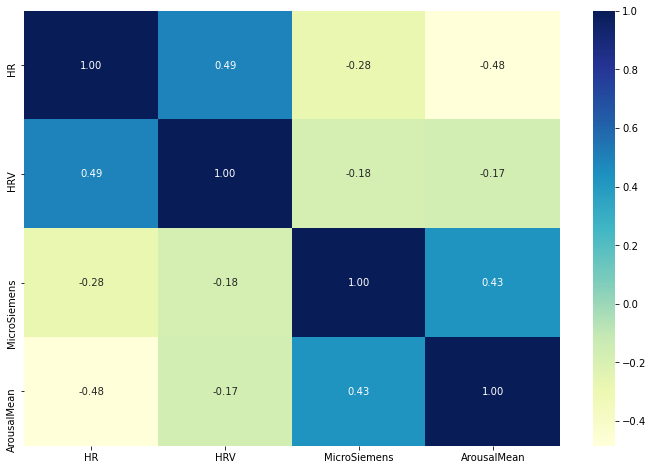

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(biometrics_df.corr(), annot=True, fmt=".2f", cmap='YlGnBu')
# plt.show()

# Model creation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [10]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
def map_to_0_and_1(arousal):
    return 0 if arousal < 5 else 1

y_train_aroused = np.array(list(map(map_to_0_and_1, y_train)))
y_test_aroused = np.array(list(map(map_to_0_and_1, y_test)))

In [11]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train_aroused)

KNeighborsClassifier()

# Prediction

In [12]:
knn.predict(X[145].reshape(1, -1))

array([1])

# TRAIN Performance Measuring

In [13]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Cross Validation \t")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))        
        
        res = cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy')
        print("Cross Validation \t")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

In [14]:
print_score(knn, X_train, y_train_aroused, X_test, y_test_aroused, train=True)

Train Result:

Accuracy score: 0.9125

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       173
           1       0.92      0.86      0.89       124

    accuracy                           0.91       297
   macro avg       0.91      0.91      0.91       297
weighted avg       0.91      0.91      0.91       297


Confusion Matrix: 
 [[164   9]
 [ 17 107]]

Cross Validation 	
Average Accuracy: 	 0.5987
Accuracy SD: 		 0.1861


In [15]:
print_score(knn, X_train, y_train_aroused, X_test, y_test_aroused, train=False)

Test Result:

accuracy score: 0.4533

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.45      0.62        75
           1       0.00      0.00      0.00         0

    accuracy                           0.45        75
   macro avg       0.50      0.23      0.31        75
weighted avg       1.00      0.45      0.62        75


Confusion Matrix: 
 [[34 41]
 [ 0  0]]

Cross Validation 	
Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000


/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Grid Search

In [16]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [17]:
params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [18]:
grid_search_cv = GridSearchCV(KNeighborsClassifier(),
                              params, 
                              n_jobs=-1,
                              verbose=1)

In [19]:
grid_search_cv.fit(X_train, y_train_aroused)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=1)

In [20]:
grid_search_cv.best_estimator_

KNeighborsClassifier(n_neighbors=2)

In [21]:
y_test_pred_grid = grid_search_cv.predict(X_test)

In [22]:
print_score(grid_search_cv, X_train, y_train_aroused, X_test, y_test_aroused, train=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Train Result:

Accuracy score: 0.9428

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       173
           1       1.00      0.86      0.93       124

    accuracy                           0.94       297
   macro avg       0.96      0.93      0.94       297
weighted avg       0.95      0.94      0.94       297


Confusion Matrix: 
 [[173   0]
 [ 17 107]]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation 	
Average Accuracy: 	 0.6397
Accuracy SD: 		 0.1468


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [23]:
print_score(grid_search_cv, X_train, y_train_aroused, X_test, y_test_aroused, train=False)

Test Result:

accuracy score: 0.5067

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.51      0.67        75
           1       0.00      0.00      0.00         0

    accuracy                           0.51        75
   macro avg       0.50      0.25      0.34        75
weighted avg       1.00      0.51      0.67        75




/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent wo

Confusion Matrix: 
 [[38 37]
 [ 0  0]]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation 	
Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [24]:
grid_search_cv.best_params_

{'n_neighbors': 2}

In [25]:
# grid_search_cv.cv_results_['mean_train_score']

In [26]:
grid_search_cv.cv_results_

{'mean_fit_time': array([0.00115561, 0.00110259, 0.00098591, 0.00200987, 0.00075483,
        0.00084639, 0.00086427, 0.00076604, 0.00078874, 0.00069022]),
 'std_fit_time': array([1.67386076e-04, 1.71066592e-04, 2.83247108e-04, 1.68350134e-03,
        2.17528701e-05, 9.61820855e-05, 1.24649648e-04, 3.55200477e-05,
        1.21088513e-04, 8.92529114e-05]),
 'mean_score_time': array([0.00751953, 0.00464597, 0.00508008, 0.00515409, 0.009797  ,
        0.00525446, 0.00799837, 0.01188893, 0.00534229, 0.00532084]),
 'std_score_time': array([0.00536751, 0.0007856 , 0.00133386, 0.00085017, 0.00471092,
        0.00085361, 0.0044088 , 0.00361328, 0.00078643, 0.00103981]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 

In [27]:
df_y_train = pd.DataFrame(data=y_test_aroused, columns=['Arousal'])
df_y_pred = pd.DataFrame(data=y_test_pred_grid, columns=['Arousal'])

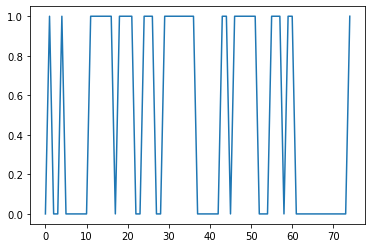

In [28]:
plt.plot(df_y_pred["Arousal"])
plt.show()

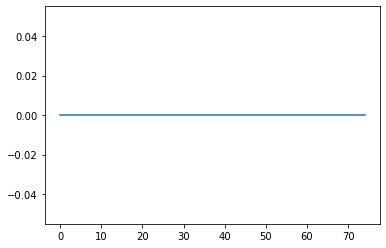

In [29]:
plt.plot(df_y_train["Arousal"])
plt.show()

In [30]:
import pickle

# save the model to disk
pickle.dump(grid_search_cv, open('../models/knn-hr-skin-model', 'wb'))
print('Done')

Done
